dataset:

---

https://github.com/liaopeiyuan/artbench

# Experiments tried so far:

**01.)  Fine tune out of the box:**


Idea: Create the simplest baseline, use default FastAI fine_tune out of the box.

Result: Model starts to overfit after 3 epochs of training on the unfrozen layers. Train loss drops, but validation loss increases.

Conclusion: Try to train only on the last layer (frozen model) for more epochs if this would produce better results.

**02.) Train only last layers:**



Idea: Train only on the last layer, with the same parameters that FastAI fine_tune uses for training on the frozen layer part, except for epoch and learning rate. Learning rate was selected from the learning rate finder results.

Result: No overfitting occurs even after training for multiple epochs, 15 in this case.

Conclusion: Could try training with unfroozing layers again, with the trained model from this as input, meaning whill will be the learner object used in next experiment.

**03.) Training of unfrozeen model, continuation of training of model from (02.).**


Idea: Simulate FastAI fine_tune, but train on frozen layers for more epochs. To achieve this,  the trained model from step 02 is used, and the learning rate finder is rerun. So in this experiment, training of all the layers will be done.

Result: Model starts to overfit again after 3 epochs, training loss is down, but validation loss increases. The error rate has not improved compared to before at any step.

Conclusion: Leave unfreezing of earlier layers for a while; it seems that this worsens the result. Maybe training parameters would need to be improved or additional regularization added to make this useful. It also makes sense to explore more training on the last layer only. Only when this is improved should experiments with unfreezing earlier layers be conducted.


**04.) Training of only last layer with default augmentations.**


Idea: Train in the same way as step 02, but add default FastAI augmentations.
These are: item_tfms=Resize(460),  batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=224, min_scale=0.75)]).

Result: Comparable results, even a bit better compared to 02.

Conclusion: Adding augmentations could make sense, but only augmentations that make sense for this dataset should be included, because some of the out-of-the-box image augmentations are meant for natural object scenes. Additionally, we are using the dataset 256x256, which means that images of different dimensions were already resized. From the paper: for the 32×32, 256×256 variants, we apply center-crop on the original images and then apply the Nicolas Robidoux resampling method to reduce artifacts during downsampling.  So it could make sense to add augmentations for regularization, maybe also after training for a while.

**05.) Training of only last layer, with larger architecture.**

Idea: Use a larger model, the next larger model in fastai after resnet18 is resnet34, train to see what happens, and try for a couple of more epochs. Use the same hyperparameters as in 02, except for learning rate and epochs.

Result: It takes 1 minute longer per epoch. The result is comparable to the result obtained with 02, but a bit better. Trained for a couple of more epochs and the model still does not overfit.

Conclusion: It could make sense to try with this architecture or even larger,   but experimenting with this should be left for later stages, when various methods have been tried.


**06.) Training of only last layer like (02.) but with increased lr. and more
epochs**

Idea: Experiments 04 and 05 produced slightly better results than experiment 02. But they both used a larger learning rate. Is it possible that the initial learning rate was too low? Also, try increasing the number of epochs.

Result: The model still does not overfit after epochs. We get improved and comparable results to 04.

Conclusion: The initial learning rate used was probably too low; results are now comparable. But just adding more epochs to get better results is not the solution.


**07.) Training of only last layer like (06.) with increased batch size(2x)**


Idea: Batch size of 64 was determined arbitrarily. Could a larger batch size be used and will it still fit in the GPUs memory? Train in the same way as 06 and determine the learning rate again.

Result: Model training works, but the end result is worse; behaviour seems to indicate that the model started overfitting.

Conclusion: Increasing batch size does not improve the result, but it is possible to run it.

**08.) Training of only last layer like (06.) with lowered batch size(/2)**


Idea: What behaviour happens if we decrease the batch size by 2.  Train the same way as 06 and determine the learning rate again.

Result: The Learning rate suggested by finder is lower now. The final result is comparable to 06.

Conclusion: If we compare the loss function from 06 and 08, we see that now, training loss starts lower from the same epoch, and while it decreases, it fluctuates up and down. Since we need to train with a lower learning rate, it could make sense to use a lower batch size as a regularization method later in training.


**09.) Training in 2 steps on only lasts layer, initial model trained**

Idea: Based on experiments, it seems that the training rate should be lowered after several epochs. We could train in two steps, first with a higher learning rate and then with a lower learning rate. Emulate the training of 02 again, with the same number of epochs, but use a higher learning rate.

Result: Results comparable to 02 were obtained.

Conclusion: We now have a learner that will be used as input in the following experiments, meaning it will be the first step of a step training.



**10.) Continuation of 09 training, step 2, lowered learning rate**

Idea: Continue training the learner, but run the learning rate finder again, so that you will run the training process with a lower learning rate.

Result: Validation loss and error rate decrease massively in the first epoch. Further training decreases train loss, but validation loss gets worse.

Conclusion: This approach of training in 2 steps makes sense. Need to try experimenting further with variations of this step, so that train loss will decrease, without having an effect on validation loss.


**11.) Continuation of 09 training, step 2, smaller batch size with lowered learning rate**

Idea: Try training with a smaller batch size, which is an idea of regularization mentioned before.

Result: Worse training and validation loss than before.

Conclusion: This does not improve on 11. Based on both experiments, it seems that the learning rate should decrease after at most 3 epochs, which is achieved with pct_start parameter. Maybe also try lowering the learning rate a bit more.

**12.) Continuation of 09 training, step 2, have smaller pct, later epochs have lowered learning rate**

Idea: Learning rate is chosen ok for the first epoch, but then the learning rate should decrease, to avoid overfitting. Training should take pct_start into account, not just be copied as 0.99 from fine_tune. This way, the learning rate will increase for a certain percentage of epochs and then decrease.  Here, pct_start is set low, so that learning only increases for a couple of epochs. Since a lower learning rate is also used than before, both div and div_final are also lower than the default in fine_tune, as we are dealing with lower learning rates here.

Result: Best result from the experiments of training in the second step. As before, validation loss goes down with the same epoch, but does not worsen in further epochs, while the training loss gets better.

Conclusion: Would need to test what would happen if we trained the whole process from the start with pct_start set in such a way that the learning rate would increase for some epochs and then decrease.

**13.) Train from start with pct_start, in live with previous result, default div and div_final**

Idea: Learning process should start from the beginning with pct_start set in such a way that learning rate increases only for the part of learning and then decreases. Here, the learning rate will increase for the first 12 epochs and then decrease. Because of this, the learning rate is set a bit higher than before. For hyperparameters div and div_final, use the same values as present in FastAI fine_tune.

Result: Managed to train for 30 epochs straight. Produced the best result so far for the training set without overfitting on validation loss. Validation loss, however, is still not comparable with 12.

Conclusion: While this model trains ok, it does not come near the accuracy on the validation set of 12, as well as 11 and 10. Did those models happen to overfit on the validation set, perhaps? At the same time, experiment 12 has a worse training loss than 13. Both experiments 12 and 13 should be evaluated on the test set data to compare accuracy.


additional ideas to try: weight decay after cetrain time, change how augmentations are done, longer, training, even larger models, dataset reduced artists, random erasing, mixup, label smoothing, tta, traing from scratch,  etc....

# Imports of libraries, creation of an experiment

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 9.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

Copy file content, select  one of these, depending if you need the models

In [ ]:
# load mlflow from the google drive
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
# load only certain experiment from mlflow, TODO make this parametrizable
!mkdir -p /content/mlruns
!mkdir -p /content/mlruns/1

!cp -r  "/content/drive/My Drive/Colab Notebooks/mlflow_data/mlruns/1/8e99bd9181e743d68dbfdc70caeb47f7"  "/content/mlruns/1/8e99bd9181e743d68dbfdc70caeb47f7"

In [ ]:
# if you need to copy all the content, it takes time because of serialized models
!cp -r  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns  /content/mlruns
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
!ls mlruns

1


In [ ]:
!ls  ./mlruns/*/ | wc -l

1


change imports

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

In [ ]:
from artworks_helpers import *
from fastai_utils import *
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

2025/08/07 09:15:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/07 09:15:45 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade bda7b8c39065 -> cbc13b556ace, add V3 trace schema columns
INFO  [alembic.runtime.migration] Running upgrade cbc13b556ace -> 770bee3ae1dd, add assessments table
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [ ]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [ ]:
active_experiment_id

'1'

# Preparation of dataloaders, model initalization with learning rate finder

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

**Alternative batch sizes to try, inital batch size was determined at random**

In [ ]:
#larger batch
BATCH_SIZE = 128

In [ ]:
#smaller batch
BATCH_SIZE = 32

In [ ]:
RESNET18_PRETRAINED = 'resnet18_pretrained'
RESNET34_PRETRAINED = 'resnet34_pretrained'

Experiments without agumentation on paintings

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
}

paintings_no_transform = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)

dls = paintings_no_transform.dataloaders(path/"train", bs=BATCH_SIZE)

Experiments with default recommended fastai agmentation on paintings

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'item_tfms': 'Resize(460)',
    'batch_tfms': '[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=224, min_scale=0.75)])',
    'batch_size': BATCH_SIZE,
}

paintings_augmented = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                get_y=parent_label,
                item_tfms=Resize(460),
                batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=224, min_scale=0.75)])

dls = paintings_augmented.dataloaders(path/"train", bs=BATCH_SIZE)

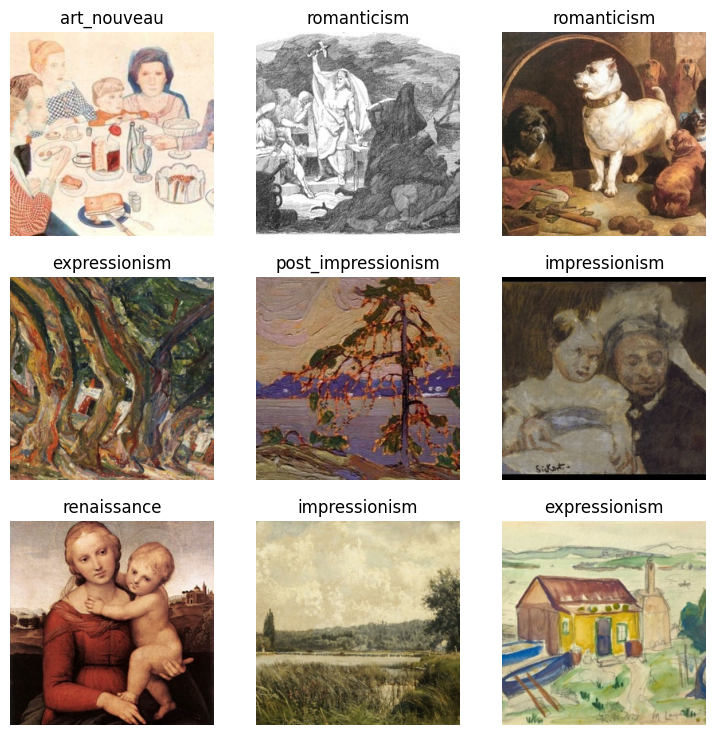

In [ ]:
dls.show_batch()

Initial training of learner from scratch


In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
params_training_all_runs['model_name'] = RESNET18_PRETRAINED

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.8MB/s]


Bigger model

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
params_training_all_runs['model_name'] = RESNET34_PRETRAINED

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Training of learner from previous snapshot

In [ ]:
def load_learner_from_run(run_id, model_saved_name, dls = None):
  local_path = mlfclient.download_artifacts(run_id, "fastai_model/" + model_saved_name)
  learner = load_learner(local_path)
  if dls is not None:
    learner.dls = dls
  return learner


In [ ]:
learn = load_learner_from_run('8e99bd9181e743d68dbfdc70caeb47f7', 'fastai_resnet18_train_only_frozen.pkl', dls)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
# Define the run ID and artifact path of the saved model
run_id = "b8d17b3a62ba4f969dae8594895019f8"
fastai_model_artifact_path = "fastai_model/fastai_resnet18_only_frozen.pkl"


# Download the artifact to a local path
local_path = mlfclient.download_artifacts(run_id, fastai_model_artifact_path)
learn = load_learner(local_path)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
learn.unfreeze()

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
format_lrs(learn_rate)

**Whole process in a single step**

{'data_split': 'random', 'split_seed': 42, 'split_valid_pct': 0.2, 'batch_tfms': 'Normalize.from_stats(*imagenet_stats)', 'batch_size': 64, 'model_name': 'resnet18_pretrained'}

metric: valley,  learning_rate:  0.001202
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: steep,  learning_rate:  0.002089
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: slide,  learning_rate:  0.002089
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: minimum,  learning_rate:  0.005754
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



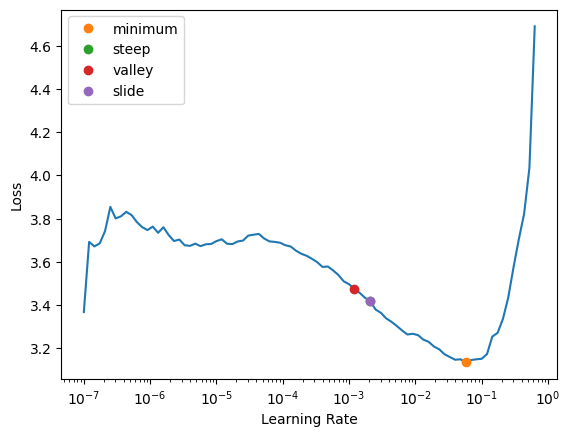

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(params_training_all_runs)
print()
format_lrs(learn_rate)

# Various experiments tried

**01.) Fine tune out of the box.**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='001_resnet18_fine_tune') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.001, 'num_epochs': 8}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.fine_tune(run_params['num_epochs'], base_lr=run_params['learning_rate'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_finetune.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.633922,1.319624,0.480800,02:09


epoch,train_loss,valid_loss,error_rate,time
0,1.280421,1.138693,0.420000,02:42
1,1.106072,1.065971,0.393000,02:41
2,0.923794,1.026161,0.380000,02:42
3,0.644394,1.105928,0.384000,02:41
4,0.370620,1.290223,0.381900,02:43
5,0.174166,1.461856,0.382600,02:42
6,0.094016,1.539362,0.379800,02:41
7,0.061379,1.559847,0.381400,02:41


artifact_uri saved as model
runs:/da50e6ef4b164b57883889fa26942ecb/fastai_model/fastai_resnet18_finetune.pkl


**02.) Train only last layer.**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='002_resnet18_train_only_frozen') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.0015, 'num_epochs': 15, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.161475,1.554093,0.543700,02:05
1,1.844958,1.398054,0.495900,02:06
2,1.643578,1.306133,0.470000,02:05
3,1.489819,1.252608,0.455600,02:07
4,1.335841,1.214101,0.442400,02:06
5,1.264485,1.184055,0.434500,02:07
6,1.253578,1.167196,0.428100,02:05
7,1.221916,1.148869,0.430700,02:06
8,1.173563,1.138947,0.424700,02:05
9,1.156616,1.118736,0.415800,02:05


artifact_uri saved as model
runs:/b8d17b3a62ba4f969dae8594895019f8/fastai_model/fastai_resnet18_only_frozen.pkl


**03.) Training of unfrozeen model, continuation of training of model from (02.).**


In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='003_resnet18_unfrozen_training') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate_start":  0.0005 / 100, "learning_rate_end": 0.0005, 'num_epochs': 8, 'pct_start': 0.3, 'div': 5.0}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.unfreeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate_start'], run_params['learning_rate_end']),
                        pct_start=run_params['pct_start'], div=run_params['div'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_unfrozen_training.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.704769,1.310202,0.472400,02:42
1,1.223490,1.125513,0.419500,02:42
2,1.041125,1.047828,0.396000,02:44
3,0.756464,1.072768,0.387000,02:44
4,0.472678,1.208831,0.386100,02:43
5,0.252182,1.406972,0.387400,02:46
6,0.137183,1.520053,0.381700,02:44
7,0.100375,1.527097,0.386900,02:45


artifact_uri saved as model
runs:/bc9ca1f9460640d5a8c0d5dfe2c17133/fastai_model/fastai_resnet18_unfrozen_training.pkl


**04.) Training of only last layer with default augmentations.**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='004_resnet18_only_frozen_default_augmentations') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 15, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_frozen_default_augmentations.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.628765,1.295346,0.470800,02:08
1,1.485617,1.249508,0.458100,02:07
2,1.372827,1.219061,0.444600,02:08
3,1.289782,1.178518,0.432900,02:07
4,1.256628,1.166359,0.434800,02:08
5,1.244383,1.157288,0.430900,02:08
6,1.213474,1.135320,0.422900,02:07
7,1.196473,1.112782,0.417600,02:07
8,1.182098,1.106188,0.409000,02:07
9,1.146363,1.103766,0.411600,02:07


artifact_uri saved as model
runs:/d98be7335c6a4f96b6abdb8a9a4a1411/fastai_model/fastai_resnet18_train_frozen_default_augmentations.pkl


**05.) Training of only last layer, with larger architecture.**


In [ ]:
params_training_all_runs['model_name'] = RESNET34_PRETRAINED

with mlflow.start_run(experiment_id=active_experiment_id, run_name='005_resnet34_train_only_frozen') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 20, 'pct_start':0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet34_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.005632,1.441173,0.507500,03:05
1,1.662062,1.319501,0.472600,03:05
2,1.504166,1.246201,0.458600,03:05
3,1.357149,1.198905,0.440900,03:04
4,1.256192,1.163298,0.437400,03:06
5,1.237579,1.136956,0.425600,03:05
6,1.194355,1.121769,0.421800,03:04
7,1.171973,1.109346,0.418900,03:06
8,1.128663,1.097558,0.412200,03:04
9,1.114048,1.082133,0.405100,03:06


artifact_uri saved as model
runs:/05393c209ab046059bc1881b45e277eb/fastai_model/fastai_resnet34_train_only_frozen.pkl


**06.) Training of only last layer like (06.) but with increased lr. and more
epochs**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='006_resnet18_train_only_frozen_larger_lr_more_epochs') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 25, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.947882,1.436921,0.512000,02:06
1,1.675512,1.329901,0.478400,02:05
2,1.498779,1.269784,0.465800,02:05
3,1.397083,1.229595,0.451300,02:06
4,1.318266,1.196535,0.444800,02:06
5,1.287378,1.177515,0.436000,02:07
6,1.248554,1.155868,0.429900,02:06
7,1.190477,1.147987,0.426000,02:06
8,1.186401,1.136500,0.423400,02:05
9,1.204077,1.129557,0.423400,02:05


artifact_uri saved as model
runs:/ee27b947e0154ababf85f0fd0295968c/fastai_model/fastai_resnet18_train_only_frozen.pkl


**07.) Training of only last layer like (06.) with increased batch size(2x)**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='007_resnet18_larger_batch_size') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 25, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.069470,1.484104,0.519900,02:11
1,1.777074,1.371832,0.487000,02:09
2,1.639107,1.302466,0.470300,02:10
3,1.475716,1.255976,0.453700,02:11
4,1.369025,1.226119,0.444900,02:09
5,1.295648,1.191658,0.433100,02:10
6,1.244474,1.172081,0.432100,02:11
7,1.206580,1.157177,0.429400,02:10
8,1.185353,1.137985,0.424700,02:09
9,1.165336,1.129291,0.419500,02:10


artifact_uri saved as model
runs:/8e99bd9181e743d68dbfdc70caeb47f7/fastai_model/fastai_resnet18_train_only_frozen.pkl


**08.) Training of only last layer like (02.) with lowered batch size(/2)**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='008_resnet18_smaller_batch_size') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.001, 'num_epochs': 25, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.107733,1.100222,0.408100,02:11
1,1.081488,1.094229,0.405700,02:12
2,1.096657,1.094045,0.406100,02:10
3,1.108894,1.091313,0.403300,02:12
4,1.077977,1.084186,0.402700,02:10
5,1.079277,1.080134,0.398700,02:10
6,1.079230,1.080414,0.401500,02:11
7,1.075167,1.081864,0.404100,02:10
8,1.075579,1.074625,0.401800,02:11
9,1.071266,1.070881,0.396000,02:10


artifact_uri saved as model
runs:/64505411accb4c568283de3e9ceba5c9/fastai_model/fastai_resnet18_train_only_frozen.pkl


**09.) Training in 2 steps on only lasts layer, initial model trained**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='009_resnet18_multistage_train_step_1') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.003, 'num_epochs': 15, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.998091,1.416731,0.500000,02:06
1,1.667070,1.300263,0.466800,02:06
2,1.429786,1.227852,0.446700,02:06
3,1.358692,1.193285,0.438400,02:05
4,1.268591,1.163264,0.434500,02:06
5,1.252242,1.129805,0.421600,02:05
6,1.220357,1.123152,0.418900,02:06
7,1.183834,1.121320,0.421100,02:05
8,1.172293,1.092951,0.413100,02:06
9,1.147544,1.094085,0.413000,02:05


artifact_uri saved as model
runs:/bf1ae9e161bc4cb286b2ab620bd1cb46/fastai_model/fastai_resnet18_train_only_frozen.pkl


**10.) Continuation of 09 training, step 2, lowered learning rate**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='010_resnet18_multistage_train_step_2_lower_lr') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.001, 'num_epochs': 10, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,0.949397,0.668997,0.225000,02:04
1,0.916739,0.665008,0.220700,02:07
2,0.920398,0.666089,0.219300,02:04
3,0.908657,0.669159,0.219200,02:04
4,0.887589,0.680755,0.231700,02:05
5,0.890516,0.685808,0.231000,02:04
6,0.902262,0.696728,0.243400,02:05
7,0.893932,0.707323,0.249100,02:05
8,0.854576,0.720598,0.254900,02:05
9,0.863937,0.728540,0.259300,02:07


artifact_uri saved as model
runs:/ce0315c38c254dadb07fc280d6dd3b68/fastai_model/fastai_resnet18_train_only_frozen.pkl


**11.) Continuation of 09 training, step 2, smaller batch size with lowered learning rate**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='011_resnet18_multistage_train_step_2_lower_batch_size') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.001, 'num_epochs': 10, 'pct_start': 0.99}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.029679,0.669185,0.225700,02:14
1,0.975239,0.668050,0.222300,02:10
2,0.954796,0.673456,0.222800,02:11
3,0.981760,0.684527,0.228200,02:10
4,0.984132,0.704423,0.237700,02:10
5,0.977531,0.720455,0.251300,02:09
6,0.961854,0.739609,0.256400,02:29
7,0.963852,0.760961,0.269500,02:17
8,0.952012,0.774619,0.281300,02:17
9,0.947883,0.794418,0.291700,02:11


artifact_uri saved as model
runs:/93c86e21d6294bff932043b944ee3980/fastai_model/fastai_resnet18_train_only_frozen.pkl


**12.) Continuation of 09 training, step 2, have smaller pct, later epochs have lowered learning rate**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='012_resnet18_multistage_train_step_2_lower_lr_with_pct') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.0005, 'num_epochs': 10, 'pct_start': 0.2, 'div':10, 'div_final':100}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,0.900827,0.690413,0.234800,02:05
1,0.927571,0.691043,0.231800,02:05
2,0.889332,0.696976,0.235400,02:05
3,0.850346,0.698165,0.236600,02:04
4,0.863198,0.699253,0.235700,02:05
5,0.878711,0.695734,0.237200,02:05
6,0.817381,0.703803,0.241900,02:05
7,0.813727,0.699818,0.238300,02:05
8,0.816697,0.695234,0.235000,02:06
9,0.818992,0.698678,0.239600,02:05


artifact_uri saved as model
runs:/dbd721cc462147baa0f3b37cd87997e7/fastai_model/fastai_resnet18_train_only_frozen.pkl


**13.) Train from start with pct_start, in live with previous result, default div and div_final**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='013_resnet18_frozen_train_pct') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.362720,1.196521,0.441900,02:06
1,1.282055,1.174133,0.433900,02:06
2,1.278297,1.164326,0.423400,02:06
3,1.263291,1.148226,0.421000,02:06
4,1.251255,1.142986,0.426500,02:07
5,1.239458,1.123818,0.424800,02:07
6,1.200054,1.102267,0.407600,02:07
7,1.188273,1.096461,0.412900,02:06
8,1.151164,1.072744,0.397900,02:07
9,1.123431,1.065337,0.399100,02:06


artifact_uri saved as model
runs:/4c86c27c616a43438a41de5dc4ac0a1b/fastai_model/fastai_resnet18_train_only_frozen.pkl


# Saving of the results back


Save the plot figure for the loss

In [ ]:
run = get_last_run_id(mlfclient, '1')

In [ ]:
import pickle

def store_train_recordings(learn, run, genres_sorted_era):
  # save loss recording plot
  loss_plot_path = "loss_plot.png"
  learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)
  mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
          artifact_path='figures')

  interp = ClassificationInterpretation.from_learner(learn)
  add_methods_to_interpetation(interp)

  # save confussion matrix image
  interp.plot_confusion_matrix_vocab(genres_sorted_era, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')
  mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
          artifact_path='figures' )

  # save interpretation object
  interp_path = "interpretation.pkl"
  with open(interp_path, "wb") as f:
      pickle.dump(interp, f)

  # Log the interpretation object as an artifact to the current MLflow run
  mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
          artifact_path='interpetation' )


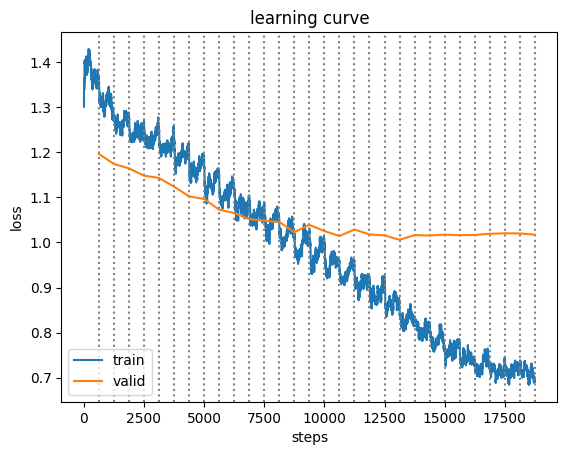

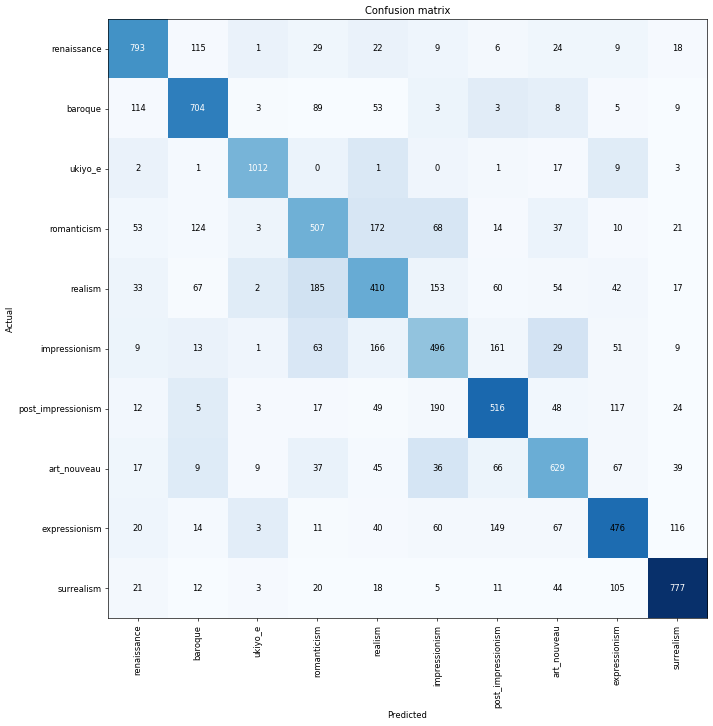

In [ ]:
store_train_recordings(learn, run, genres_sorted_era)

**Upper steps, but each step is done one by one**

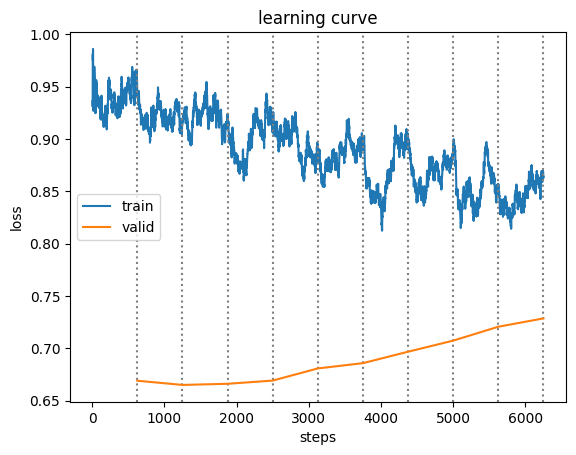

In [ ]:
loss_plot_path = "loss_plot.png"
learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)

# Log the plot as an artifact to the  MLflow run
mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
        artifact_path='figures')

Save the classification interpetation

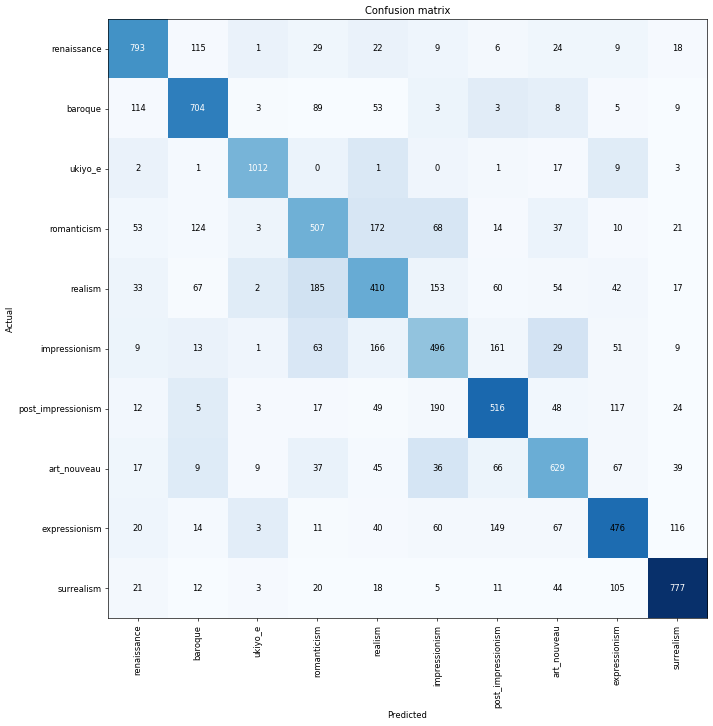

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
add_methods_to_interpetation(interp)

interp.plot_confusion_matrix_vocab(genres_sorted_era, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')

mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
        artifact_path='figures' )

How to save and load the interpretation object

In [ ]:
import pickle

# Assuming 'interp' is your fastai Interpretation object
interp_path = "interpretation.pkl"
with open(interp_path, "wb") as f:
    pickle.dump(interp, f)

# Log the interpretation object as an artifact to the current MLflow run
mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
        artifact_path='interpetation' )

**Show how learning rate was changed during plot**

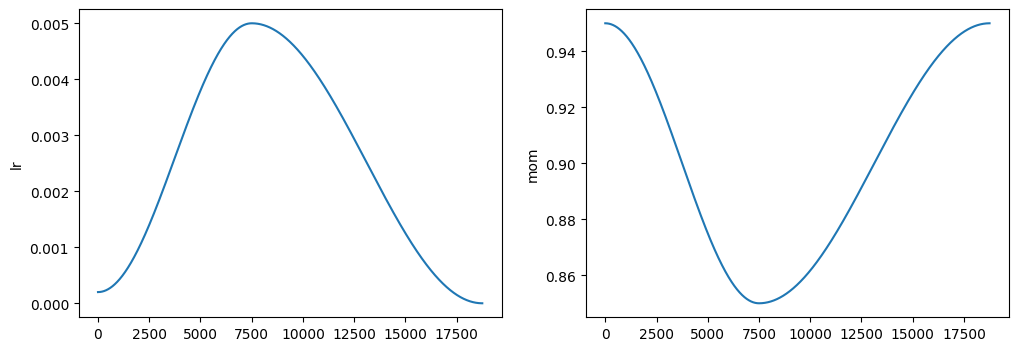

In [ ]:
learn.recorder.plot_sched()
plot_sched_figure = plt.gcf()

image_plot_sched = 'scheduled_lr_mom.png'

# you can retrieve the last image with this, since plot is bot returned

# Now you can work with the last_figure object, e.g., save it
plot_sched_figure.savefig(image_plot_sched)

mlfclient.log_artifact(run.info.run_id, local_path=image_plot_sched,
        artifact_path='figures' )


**How to display most confused classes**

In [ ]:
interp.print_classification_report()

                    precision    recall  f1-score   support

       art_nouveau       0.69      0.55      0.61      1009
           baroque       0.69      0.69      0.69       998
     expressionism       0.49      0.54      0.51      1016
     impressionism       0.50      0.45      0.47      1046
post_impressionism       0.44      0.48      0.46       956
           realism       0.43      0.40      0.41       981
       renaissance       0.62      0.82      0.71       954
       romanticism       0.55      0.45      0.50       991
        surrealism       0.73      0.75      0.74      1023
           ukiyo_e       0.95      0.98      0.96      1026

          accuracy                           0.61     10000
         macro avg       0.61      0.61      0.61     10000
      weighted avg       0.61      0.61      0.61     10000



In [ ]:
interp.print_classification_report()

                    precision    recall  f1-score   support

       art_nouveau       0.74      0.77      0.75       954
           baroque       0.81      0.81      0.81       991
     expressionism       0.64      0.67      0.65      1046
     impressionism       0.61      0.62      0.62       956
post_impressionism       0.63      0.65      0.64      1023
           realism       0.61      0.53      0.57       981
       renaissance       0.84      0.87      0.85      1026
       romanticism       0.68      0.64      0.66       998
        surrealism       0.85      0.84      0.85      1009
           ukiyo_e       0.98      0.99      0.98      1016

          accuracy                           0.74     10000
         macro avg       0.74      0.74      0.74     10000
      weighted avg       0.74      0.74      0.74     10000



In [ ]:
interp.print_classification_report()

                    precision    recall  f1-score   support

       art_nouveau       0.66      0.66      0.66       954
           baroque       0.66      0.71      0.69       991
     expressionism       0.53      0.50      0.52       956
     impressionism       0.49      0.50      0.49       998
post_impressionism       0.52      0.53      0.52       981
           realism       0.42      0.40      0.41      1023
       renaissance       0.74      0.77      0.76      1026
       romanticism       0.53      0.50      0.52      1009
        surrealism       0.75      0.76      0.76      1016
           ukiyo_e       0.97      0.97      0.97      1046

          accuracy                           0.63     10000
         macro avg       0.63      0.63      0.63     10000
      weighted avg       0.63      0.63      0.63     10000



Checking that the most confused counts follow the genres_era_sorted ordering, closer together means more likely to be confused

In [ ]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [ ]:
distance_formula = partial(distance, genres_sorted_era)
confused_counts = interp.most_confused()

In [ ]:
for count in confused_counts:
    print((count[0], count[1],  distance_formula(count[0], count[1]), count[2]))

('impressionism', 'post_impressionism', 1, np.int64(219))
('baroque', 'renaissance', 1, np.int64(186))
('romanticism', 'realism', 1, np.int64(172))
('post_impressionism', 'expressionism', 2, np.int64(170))
('realism', 'romanticism', 1, np.int64(166))
('impressionism', 'realism', 1, np.int64(162))
('post_impressionism', 'impressionism', 1, np.int64(159))
('expressionism', 'post_impressionism', 2, np.int64(155))
('realism', 'impressionism', 1, np.int64(138))
('romanticism', 'baroque', 2, np.int64(130))
('surrealism', 'expressionism', 1, np.int64(127))
('expressionism', 'surrealism', 1, np.int64(113))
('art_nouveau', 'post_impressionism', 1, np.int64(100))
('art_nouveau', 'expressionism', 1, np.int64(98))
('impressionism', 'expressionism', 3, np.int64(87))
('romanticism', 'renaissance', 3, np.int64(81))
('renaissance', 'baroque', 1, np.int64(76))
('realism', 'post_impressionism', 2, np.int64(74))
('realism', 'baroque', 3, np.int64(66))
('romanticism', 'impressionism', 2, np.int64(58))
('a

## Evaluation learner object on test dataset

In [ ]:
test_dataloaders = paintings_no_transform.dataloaders((path/'test'), with_labels=True)


In [ ]:
learner_empty = vision_learner(dls, resnet18, metrics=error_rate)
predictions, targets = learner_empty.get_preds(dl=test_dataloaders)
accuracy(predictions, targets).item()

0.08837500214576721

experiment with saved

In [ ]:
learner_loaded = load_learner_from_run('8e99bd9181e743d68dbfdc70caeb47f7', 'fastai_resnet18_train_only_frozen.pkl', dls)
predictions, targets = learner_loaded.get_preds(dl=test_dataloaders)
accuracy(predictions, targets).item()

0.609250009059906

artworks_classification_resnet18_frozen_train_pct_

In [ ]:
!cp -r  "/content/drive/My Drive/Colab Notebooks/mlflow_data/mlruns/1/4c86c27c616a43438a41de5dc4ac0a1b"  "/content/mlruns/1/4c86c27c616a43438a41de5dc4ac0a1b"
learner_loaded = load_learner_from_run('4c86c27c616a43438a41de5dc4ac0a1b', 'fastai_resnet18_train_only_frozen.pkl', dls)
predictions, targets = learner_loaded.get_preds(dl=test_dataloaders)
accuracy(predictions, targets).item()

0.6222500205039978

In [ ]:
!cp -r  "/content/drive/My Drive/Colab Notebooks/mlflow_data/mlruns/1/dbd721cc462147baa0f3b37cd87997e7"  "/content/mlruns/1/dbd721cc462147baa0f3b37cd87997e7"

learner_loaded = load_learner_from_run('dbd721cc462147baa0f3b37cd87997e7', 'fastai_resnet18_train_only_frozen.pkl', dls)
predictions, targets = learner_loaded.get_preds(dl=test_dataloaders)
accuracy(predictions, targets).item()

0.6208750009536743

# Mlfow how to start server to view results in colab


In [ ]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

   1147 ?        R      0:00 /usr/bin/python3 /usr/local/bin/mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000


In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)

MLflow Tracking UI: https://16f94b62fd91.ngrok-free.app


'https://16f94b62fd91.ngrok-free.app'

With MLflow, you can resume a run that has ended. This is a useful feature for continuing training from a checkpoint or adding more information to an existing run.

You can resume a run by using the mlflow.start_run() function with the run_id of the ended run.

# Copy Mlflow back to server

In [ ]:
# copy mlflow mlruns.db back to server
!cp   /content/mlruns.db  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

In [ ]:
# copy mlflow_data back to server
!cp -r /content/mlruns    /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data

In [ ]:
# check that counts for runs match
# this is no longer usefull, if not all runs were copied
!ls  ./mlruns/*/ | wc -l
!ls  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns/*/ | wc -l

9
9
